HHU Deep Learning in Life Science: Generative Models, Prof. Dr. **Markus Kollmann**, WS 2025-2026

Tutors: **Felix Michels** and **Adaloglou Nikolaos**
## Assignment 1 - Variational Autoencoder (VAE)

- **Submission link**: https://uni-duesseldorf.sciebo.de/s/ZSjNF5GWWzHWcmf 
- **Deadline**: 30/11/2025
- **Note**: Rename your file BEFORE submitting!
- If you encounter issues that might apply to other students, please notify others in the group chat.

#### How to submit
- Submit the solved notebook (not a zip) with your full name (`NAME_SURNAME`) plus assingment number for the filename as an indicator, e.g `max_mustermann_a1.ipynb` for `assignment 1`. If you have more names, please use only the first one for all homeworks.
- Please use the same naming convention `NAME_SURNAME_aX` to faciliate the tutors.
- You are free to modify our code as you see fit.
  




## General instructions
---
Instructions about the exercises and the course structure.

**Course Structure & Grading:**

-  A weekly/biweekly exercise is uploaded after the lecture, and you have 1 or 2 weeks to complete it. Your solution will be graded as PASS/FAIL. 
- You need 80% of exercises completed to be eligible for the final written exam
- Expected results are provided as guidance, but exact matches aren't always required 
- Typically, we provide you with the expected results (e.g., 90% test classification accuracy), but you don't always need to match the expected result to get the point.
- Importantly, your code should produce the last result, based on which you will be graded.
- We will not rerun your notebooks; your submission will be evaluated based on the cell's output.

The exercises are not going to affect your final grade, it's simply an admission to participate in the final exam. For this reason, AI tools and chatbots are *not* prohibited. You are responsible for your code and its outcome.

**Submission Policy:**

You are incentivized to ask questions and, of course, help each other to some extent through Rocketchat. Please use threads to resolve different issues/questions. We will try to catch up and answer the questions as much as our agendas enable us. If you are sick or don't submit for some personal reason, we will not give you an extension. Please don't spam us for individual extensions; it's unfair to the other students who submit by the specified deadlines. Extensions are only given in extreme cases to all students, such as if Sciebo is down for a few days, etc. 



If you have issues with the grading procedure, or administrative problems with the course, grading, etc., contact Prof. Kollmann. The tutors are not responsible for the administrative aspects of the course.

Feel free to ask us for any information or questions about the course during the tutoring classes (after the lecture). The tutoring class is not just for us to show you the solution. It can become more interactive if you participate and ask questions. If you don't have any questions, we assume you understand everything, and we will only be able to present the solution to the current exercise.

**AI Tools & Collaboration:**
- AI tools and chatbots are permitted (you're responsible for understanding your code)
- Collaboration through Rocketchat is encouraged - use threads for different topics


**Tutoring Sessions:**
- Attend tutoring classes after lectures for interactive Q&A
- Come prepared with questions to make sessions more valuable

---



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import os 
from pathlib import Path
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tqdm import tqdm

In [2]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:1") if cuda else torch.device("cpu")
print(f"Using device {device}")

outdir = Path('student_figures')
os.makedirs(outdir, exist_ok=True)

Using device cuda:1


# Part A: VAEs in 2D Toy Datasets

### Datasets

In [3]:
def sample_data_1():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]

def sample_data_2():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]) \
    @ ([[np.sqrt(2)/2, np.sqrt(2)/2],  \
      [-np.sqrt(2)/2, np.sqrt(2)/2]])

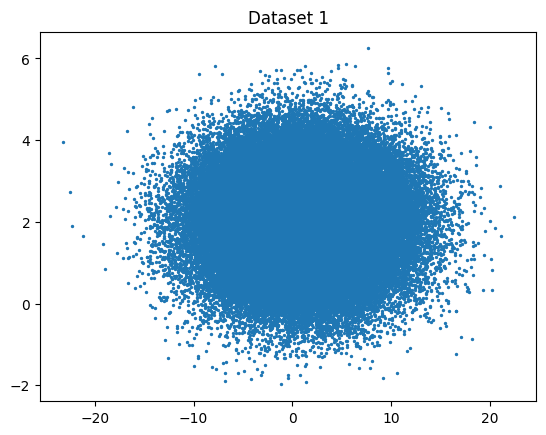

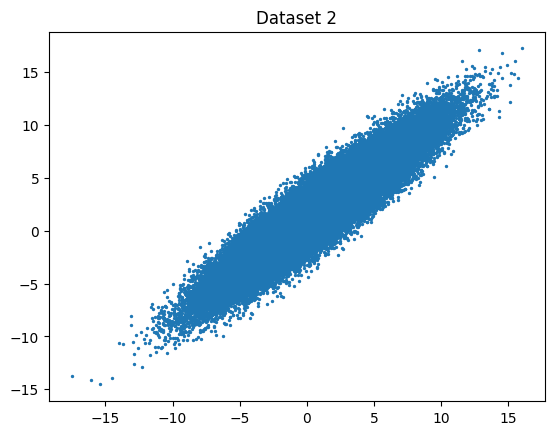

In [4]:
X1 = sample_data_1()
N_test1 = 5000
N_val1 = 5000
N_train1 = X1.shape[0] - N_val1 - N_test1
device = torch.device('cuda')
train_dataset1 = TensorDataset(torch.as_tensor(X1[:N_train1], dtype=torch.float32, device=device))
val_dataset1 = TensorDataset(torch.as_tensor(X1[N_train1:-N_test1], dtype=torch.float32, device=device))
test_dataset1 = TensorDataset(torch.as_tensor(X1[-N_test1:], dtype=torch.float32, device=device))

X2 = sample_data_2()
N_test2 = 5000
N_val2 = 5000
N_train2 = X2.shape[0] - N_val2 - N_test2
train_dataset2 = TensorDataset(torch.as_tensor(X2[:N_train2], dtype=torch.float32, device=device))
val_dataset2 = TensorDataset(torch.as_tensor(X2[N_train2:-N_test2], dtype=torch.float32, device=device))
test_dataset2 = TensorDataset(torch.as_tensor(X2[-N_test2:], dtype=torch.float32, device=device))

plt.title('Dataset 1')
plt.scatter(X1[:, 0], X1[:, 1], s=2);
plt.figure()
plt.title('Dataset 2')
plt.scatter(X2[:, 0], X2[:, 1], s=2);

### Models

In [5]:
class MLP(nn.Module):
    """Multilayer perceptron."""   
    def __init__(self, input_size, hidden_sizes, output_size, hidden_activation=F.relu):
        super().__init__()
        self.hidden_activation = hidden_activation
        self.layers = nn.ModuleList()
        for layer_in, layer_out in zip([input_size] + hidden_sizes, hidden_sizes + [output_size]):
            self.layers.append(nn.Linear(layer_in, layer_out))
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
            x = self.hidden_activation(x)
        x = self.layers[-1](x)
        return x

### Task A1: Implement the VAE

- The following class methods are optional to implement and serve as a guideline. Feel free to write your own implementation.
- In part B, we use the same implementation, where flatten and sigmoid will be instansiated with True.
**Objective:** Complete the VAE implementation with encoder-decoder architecture and reparameterization trick.

**Key Requirements:**
- Implement the `forward()` method with proper loss calculations
- The encoder and decoder neural nets output mean and log-variance for their respective distribution
- Use the reparameterization trick for sampling from the posterior
- Calculate KL divergence and negative log-likelihood losses
- Return reconstruction, latent sample, ELBO, KL loss, and NLL loss
- Implement the `sample()` method.

**Implementation Notes:**
- For Part B (MNIST), set `flatten=True` and `sigmoid=True`
- The provided method signatures are optional - feel free to use your own approach
- Ensure proper gradient flow through the reparameterization trick

**Mathematical Background:**
- Posterior: q_φ(z|x) = N(z; μ_φ(x), σ²_φ(x))
- Prior: p(z) = N(z; 0, I)
- Decoder: p_θ(x|z) = N(x; μ_θ(z), σ²_θ(z))


In [6]:
class VAE(nn.Module):
    def __init__(self, input_size, latent_size, encoder_sizes, decoder_sizes, hidden_activation=F.relu,
                 flatten=False, sigmoid=False):
        """Variational Autoencoder (VAE) model.
        Args:
            input_size (int): _dimension of input data_
            latent_size (int): _dimension of latent variable_
            encoder_sizes (list): _sizes of hidden layers in encoder MLP_
            decoder_sizes (list): _sizes of hidden layers in decoder MLP_
            hidden_activation (callable, optional): _activation function for hidden layers_. Defaults to F.relu.
            flatten (bool, optional): _if True, flattens the input_. Defaults to False.
            sigmoid (bool, optional): _if True, applies sigmoid activation to the output_. Defaults to False.
        """
        super().__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.flatten = flatten
        self.sigmoid = sigmoid
        # The output is 2 * latent_size to output both mean and log-variance
        # for both encoder and decoder
        self.encoder = MLP(input_size, encoder_sizes, 2 * latent_size, hidden_activation)
        self.decoder = MLP(latent_size, decoder_sizes, 2 * input_size, hidden_activation)
        
    def forward(self, x):
        ### START CODE HERE ###
        if self.flatten:
            x = x.view(x.shape[0], -1)
        
        z_latent = self.encode(x)
        
        mu, log_var = z_latent.chunk(2, dim=-1)
        std = torch.exp(0.5 * log_var)
        z = self.sample_posterior(mu, std)

        x_pred , x_mu, log_var_x = self.decode(z)

        nll = 0.5* (log_var_x + torch.pow(x-x_mu, 2) / torch.exp(log_var_x)).sum(dim=1).mean()
        kl = 0.5 * (torch.pow(mu, 2) + torch.exp(log_var) - log_var - 1.0).sum(dim=1).mean()

        elbo = -(nll + kl)
        ### END CODE HERE ###

        # Return values:
        # x_pred : reconstruction of input x
        # z: latent variable sampled from posterior distribution p(z|x)
        # nll: negative log likelihood loss = mse for Gaussian distribution
        # kl: Kullback-Leibler-divergence for multivariate normal distributions
        # ELBO: evidence lower bound
        return x_pred, z, elbo, kl, nll

    def encode(self, x):
        # No need to use this class method, this is just our implementation
        ### START CODE HERE ###
        z = self.encoder(x)
        return z
        ### END CODE HERE ###
    
    def decode(self, z, noise=True):
        ### START CODE HERE ###
        z = self.decoder(z)
        x_mu, log_var_x = z.chunk(2, dim=-1)
        if self.sigmoid:
            x_mu = torch.sigmoid(x_mu)
            log_var_x = torch.clamp(log_var_x, -4, 4)

        if noise:
            eps = torch.randn_like(x_mu)
            std = torch.exp(0.5 * log_var_x)
            x_pred = x_mu + std * eps
        else:
            x_pred = x_mu
        ### END CODE HERE ###

        return x_pred , x_mu, log_var_x # shape: [batch_size, input_size]

    def sample(self, batch_size, decoder_noise=False):
        """
        Samples from the generative model p(x) = ∫p(x|z)p(z) dz
        Args:
            batch_size (int): number of samples to generate
            decoder_noise (bool, optional): if True, samples from p(x|z), otherwise uses the mean of p(x|z). Defaults to False.
        Returns:
            x_sampled (torch.Tensor): samples from the generative model of shape [batch_size, input_size]
        """
        with torch.no_grad():
            ### START CODE HERE ###
            z = self.sample_prior(batch_size)
            x_sampled , _, _ = self.decode(z, noise=decoder_noise)
            ### END CODE HERE ###
            return x_sampled
    
    def sample_prior(self, batch_size, device=None):
        """Samples from the prior p(z) = N(0, I)"""
        if device is None:
            device = next(self.parameters()).device
        z = torch.randn(batch_size, self.latent_size, device=device) 
        return z # [bs, latent_size]
    
    def sample_posterior(self, mean, std):
        """this implements the reparameterization trick"""
        ### START CODE HERE ###
        eps = torch.randn_like(mean)
        z = mean + std * eps
        ### END CODE HERE ###
        return z
    
    def encode_latent(self, x):
        ### START CODE HERE ###
        enc_out = self.encode(x)
        mu, log_var = enc_out.chunk(2, dim=-1)
        std = torch.exp(0.5 * log_var)
        z = self.sample_posterior(mu, std)
        ### END CODE HERE ###
        return z

### Task A2: Implement the training logic



**Objective:** Complete the training loop for Beta-VAE with adjustable KL weighting.

**Key Requirements:**
- Implement the forward pass and loss computation for each mini-batch. Implement the loss based on the VAE implementation.
- Use the Beta-VAE objective: Loss = MSE + β × KL_divergence
- For Part A, use β = 1 (standard VAE)

**Mathematical Formula:**
$$ L = \text{NLL} + \beta \cdot \text{KL} = -\log p_\theta(x|z) + \beta \cdot D_{KL}(q_\phi(z|x) || p(z)) $$
- MSE (mean square error) is the negative log likelihood given a gaussian distribution


In [7]:
def train_vae(model, optimizer, train_loader, val_loader, test_loader=None, figtitle=None, num_epochs=10, beta=1.0):
    train_elbo_history = []
    train_kl_history = []
    train_nll_history = []
    
    val_elbo_history = []
    val_kl_history = []
    val_nll_history = []
    device = next(model.parameters()).device
    for epoch in tqdm(range(num_epochs)):
        for minibatch in train_loader:
            # elbo, kl, nll must be computed for each minibatch
            ### START CODE HERE ###
            optimizer.zero_grad()
            x_pred, z, elbo, kl, nll = model(minibatch[0].to(device))
            loss = nll + beta * kl
            loss.backward()
            optimizer.step()
            ### END CODE HERE ###

            train_elbo_history.append(elbo.item())
            train_kl_history.append(kl.item())
            train_nll_history.append(nll.item())
    
        with torch.no_grad():
            elbo, kl, nll = zip(*[tuple(t.item() for t in model(minibatch[0].to(device))[2:]) for minibatch in val_loader])    
            val_elbo_history.append(np.mean(elbo))
            val_kl_history.append(np.mean(kl))
            val_nll_history.append(np.mean(nll))
    
    if test_loader is not None:
        with torch.no_grad():
            elbo, kl, nll = zip(*[tuple(t.item() for t in model(minibatch[0].to(device))[2:]) for minibatch in test_loader])    
            test_elbo = np.mean(elbo)
            test_kl = np.mean(kl)
            test_nll = np.mean(nll)
    
    
    num_plots = 3
    fig, axes = plt.subplots(1, num_plots, figsize=(16,3))
    if figtitle is not None:
        fig.suptitle(figtitle)
    
    x_plot_train = np.arange(len(train_elbo_history)) / len(train_loader)
    x_plot_val = np.arange(num_epochs) + 1
    
    axes[0].set_title('ELBO')
    axes[0].plot(x_plot_train, train_elbo_history, label='train', zorder=1)
    axes[0].scatter(x_plot_val, val_elbo_history, color='C1', label='val', zorder=2)
    if test_loader is not None:
        axes[0].axhline(test_elbo, color='C2', label='test', zorder=0)
    axes[0].legend()
    
    axes[1].set_title('KL divergence')
    axes[1].plot(x_plot_train, train_kl_history, label='train', zorder=1)
    axes[1].scatter(x_plot_val, val_kl_history, color='C1', label='val', zorder=2)
    if test_loader is not None:
        axes[1].axhline(test_kl, color='C2', label='test', zorder=0)
    axes[1].legend()
    
    axes[2].set_title('Negative log likelihood')
    axes[2].plot(x_plot_train, train_nll_history, label='train', zorder=1)
    axes[2].scatter(x_plot_val, val_nll_history, color='C1', label='val', zorder=2)
    if test_loader is not None:
        axes[2].axhline(test_nll, color='C2', label='test', zorder=0)
    axes[2].legend()
    
    fig.subplots_adjust(top=0.8)
    
    fig2 = None
    if test_loader:
        fig2, axes = plt.subplots(1, 3, figsize=(16,3), sharex=True, sharey=True)
        original_data = torch.cat([minibatch[0] for minibatch in test_loader], dim=0).cpu().numpy()
        axes[0].set_title('Original data')
        axes[0].scatter(original_data[:, 0], original_data[:, 1], s=2)
        
        samples = model.sample(5000, decoder_noise=True).cpu().numpy()
        axes[1].set_title('Samples (with decoder noise)')
        axes[1].scatter(samples[:, 0], samples[:, 1], s=2)
        
        samples = model.sample(5000, decoder_noise=False).cpu().numpy()
        axes[2].set_title('Samples (without decoder noise)')
        axes[2].scatter(samples[:, 0], samples[:, 1], s=2)
    
        print(f'Final test performance: ELBO = {test_elbo:.5f}, KL = {test_kl:.5f}, NLL = {test_nll:.5f}')
    return fig, fig2


#### Hyperparameters

Variational autoencoder with
- prior p(z) = N(z; 0, I).
- posterior q_θ(z|x) = N(z; µ_θ(x), Σ_θ(x))) with diagonal covariance matrix
- decoder p_θ(x|z) = N(x; µ_θ(z), Σ_θ(z)) with diagonal covariance matrix


100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


Final test performance: ELBO = -2.65364, KL = 0.23487, NLL = 2.41877


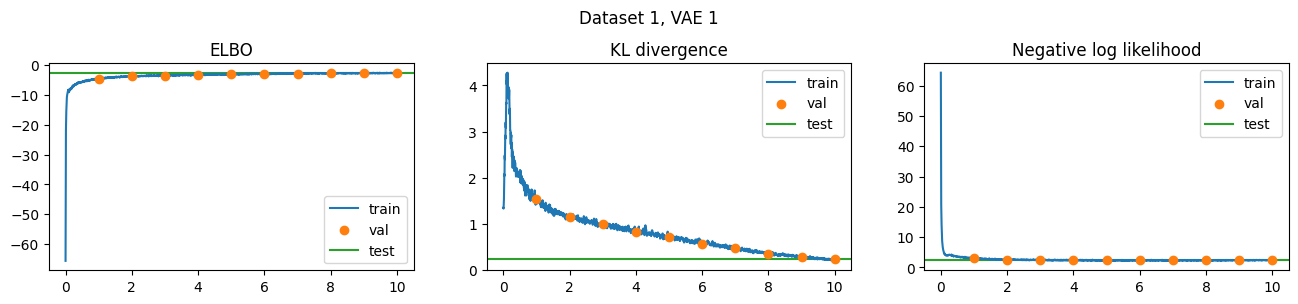

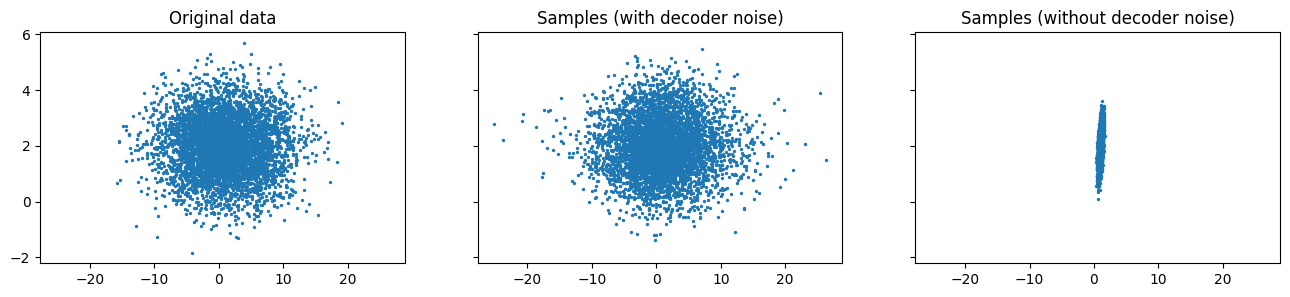

In [8]:
input_size = 2
latent_size = 2
encoder_sizes = [20]
decoder_sizes = []
hidden_activation = F.relu
lr = 1e-2
batch_size = 512
num_epochs = 10
train_loader = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset1, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)
model = VAE(input_size, latent_size, encoder_sizes, decoder_sizes, hidden_activation).to(device)
optimizer = optim.Adam(model.parameters(), lr)
fig, fig2 = train_vae(model, optimizer, train_loader, val_loader, test_loader, figtitle=f'Dataset 1, VAE 1')
# save both figures
fig.savefig(outdir / 'part_a_vae_dataset1.png', bbox_inches='tight')
fig2.savefig(outdir / 'part_a_vae_dataset1_samples.png', bbox_inches='tight')

#### Dataset 2

100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Final test performance: ELBO = -2.63644, KL = 1.61253, NLL = 1.02391


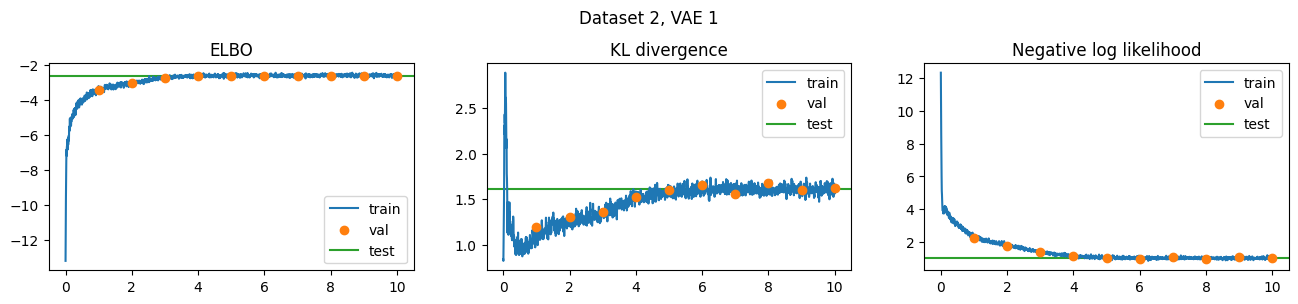

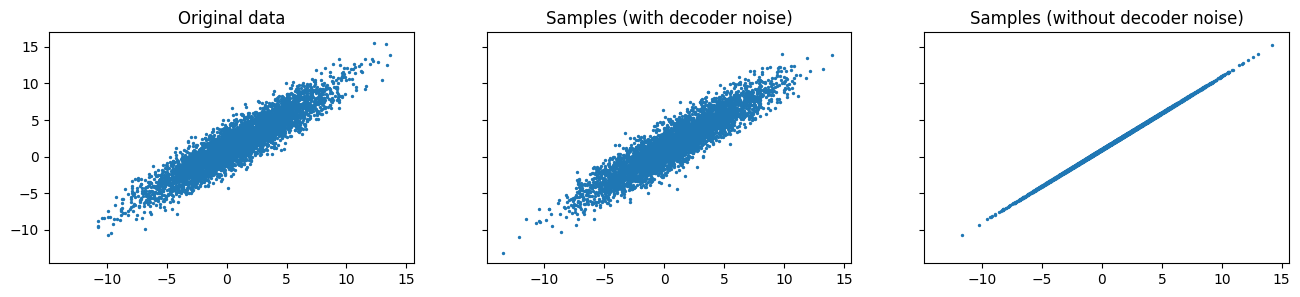

In [9]:
train_loader = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset2, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)
model = VAE(input_size, latent_size, encoder_sizes, decoder_sizes, hidden_activation).to(device)
optimizer = optim.Adam(model.parameters(), lr)
fig, fig2 = train_vae(model, optimizer, train_loader, val_loader, test_loader, figtitle=f'Dataset 2, VAE 1')
fig.savefig(outdir / 'part_a_vae_dataset2.png', bbox_inches='tight')
fig2.savefig(outdir / 'part_a_vae_dataset2_samples.png', bbox_inches='tight')

### Dataset 3

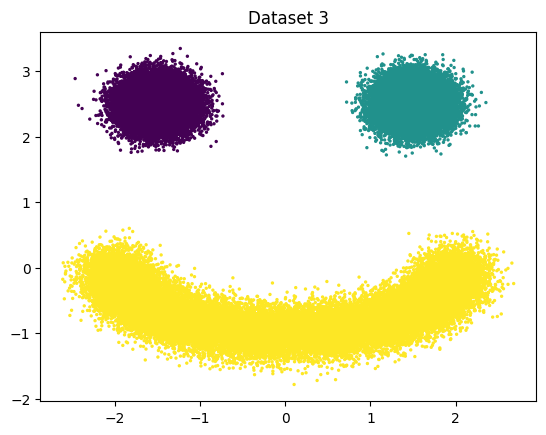

In [10]:
def sample_data_3():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]
    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

X3, y3 = sample_data_3()
N_test3 = 20000
N_val3 = 5000
N_train3 = X3.shape[0] - N_val3 - N_test3
train_dataset3 = TensorDataset(torch.as_tensor(X3[:N_train3], dtype=torch.float32, device=device))
val_dataset3 = TensorDataset(torch.as_tensor(X3[N_train3:-N_test3], dtype=torch.float32, device=device))
test_dataset3 = TensorDataset(torch.as_tensor(X3[-N_test3:], dtype=torch.float32, device=device))
plt.title('Dataset 3')
plt.scatter(X3[:, 0], X3[:, 1], c=y3, s=2);

### Training for Dataset 3

100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Final test performance: ELBO = -0.91093, KL = 0.91048, NLL = 0.00044


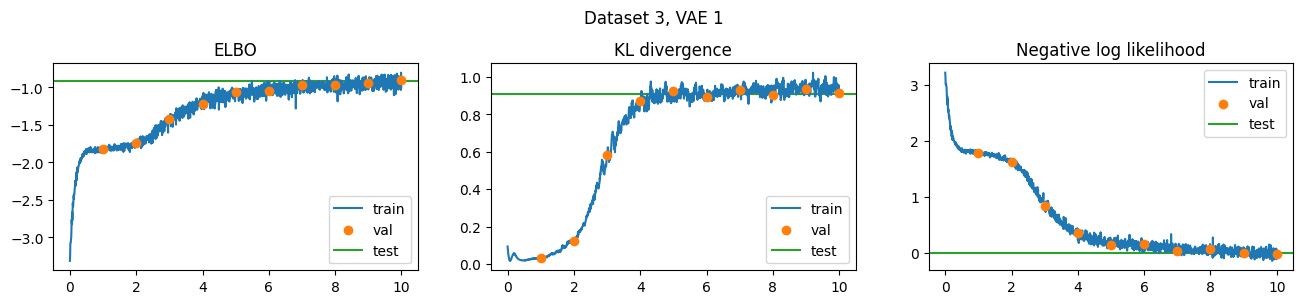

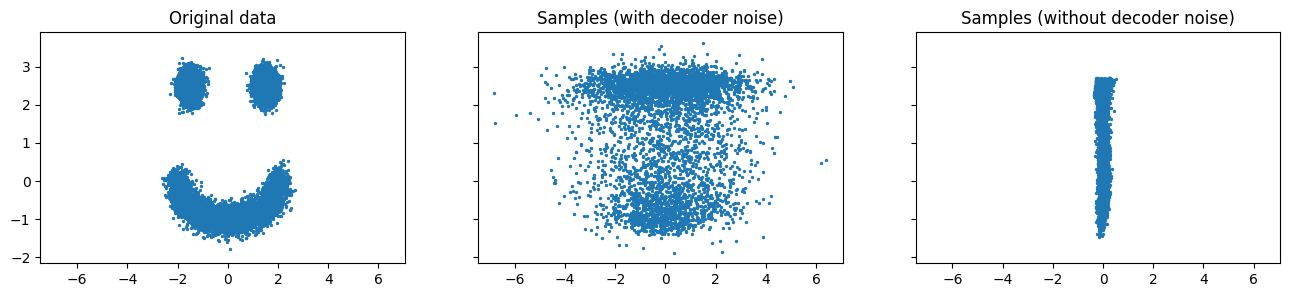

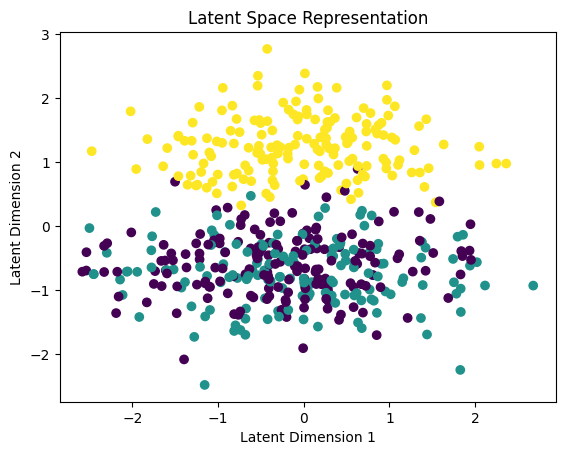

In [11]:
input_size = 2
latent_size = 2
encoder_sizes = [150, 250] # two hidden layers
decoder_sizes = [250, 150] # two hidden layers
lr = 1e-4
batch_size = 500
num_epochs = 10
train_loader = DataLoader(train_dataset3, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset3, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset3, batch_size=batch_size, shuffle=False)
model = VAE(input_size, latent_size, encoder_sizes, decoder_sizes, hidden_activation).to(device)
optimizer = optim.Adam(model.parameters(), lr)
fig, fig2 = train_vae(model, optimizer, train_loader, val_loader, test_loader, figtitle=f'Dataset 3, VAE 1')
fig.savefig(outdir / 'part_a_vae_dataset3.png', bbox_inches='tight')
fig2.savefig(outdir / 'part_a_vae_dataset3_samples.png', bbox_inches='tight')

plt.figure()
plt.title('Latent Space Representation')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
with torch.no_grad():
    z = model.encode_latent(torch.as_tensor(X3[:500], dtype=torch.float32, device=device)).cpu().numpy()
    plt.scatter(z[:, 0], z[:, 1], c=y3[:500])
plt.savefig(outdir / 'part_a_vae_dataset3_latent.png', bbox_inches='tight')


# Part B - vanilla VAE and Beta VAE on images

This part is about implementing an Autoencoder, a vanilla VAE and a Beta VAE on the MNIST dataset of handwritten digits and exploring their characteristics with regards to the latent space.


Let's start by defining the dataset.

In [12]:
torch.manual_seed(0)
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True),
        batch_size=512,
        shuffle=True)

val_data = torch.utils.data.DataLoader(
              torchvision.datasets.MNIST('./data',
                     transform=torchvision.transforms.ToTensor(),
                     train=False,
                     download=False),
              batch_size=1024,
              shuffle=False)

### Task B1: Autoencoder Implementation

**Objective:** Implement a standard autoencoder for comparison with VAE variants.

**Key Requirements:**
- Complete the `forward()` methods in `Encoder` and `Decoder` classes
- Implement the training function with MSE reconstruction loss
- Ensure proper tensor reshaping: flatten input (28×28 → 784) and reshape output (784 → 28×28)
- Loss function: MSE between input and reconstruction. No regularization.

In [13]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.actv1 = nn.ReLU()
        self.linear2 = nn.Linear(512, latent_dims)
    
    def forward(self, x):
        ### START CODE HERE ###
        x = x.view(x.shape[0], -1)
        out = self.linear1(x)
        out = self.actv1(out)
        out = self.linear2(out)
        ### END CODE HERE ###
        return out 

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.actv1 = nn.ReLU()
        self.linear2 = nn.Linear(512, 784)
        
        
    def forward(self, z):
        ### START CODE HERE ###
        out = self.linear1(z)
        out = self.actv1(out)
        out = self.linear2(out)
        ### END CODE HERE ###
        # Note: reshape to image dimensions
        out = out.view(z.shape[0], 1, 28, 28)
        return out

class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def decode(self, z):
        return self.decoder(z) # includes sigmoid
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

def train_ae(autoencoder, data, opt, num_epochs=20):
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        count = 0.0
        for x, y in data:
            ### START CODE HERE ###
            x = x.to(device)
            opt.zero_grad()
            x_hat, z = autoencoder(x)
            loss = F.mse_loss(x_hat, x, reduction='mean')
            loss.backward()
            opt.step()
            ### END CODE HERE ###
            epoch_loss += loss.item()
            count += 1
            ### END CODE HERE ###
    return autoencoder

### Task B2: Train Multiple Model Variants

**Objective:** Train and compare autoencoder with VAEs using different β values.

**Models to Train:**
1. **Standard Autoencoder** (no regularization)
2. **VAE with β=1** (standard VAE)
3. **VAE with β=3** (moderate disentanglement)
4. **VAE with β=10** (high disentanglement)

**Training Configuration:**
- Epochs: 15-20
- Latent dimension: 2 (enables direct 2D visualization)

- **Reccomended**: Save all VAEs in a dictionary with their beta as the key

100%|██████████| 20/20 [01:01<00:00,  3.09s/it]


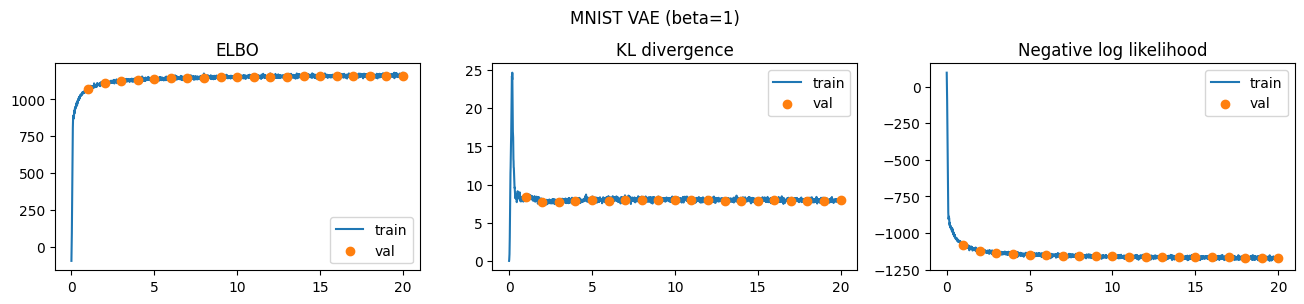

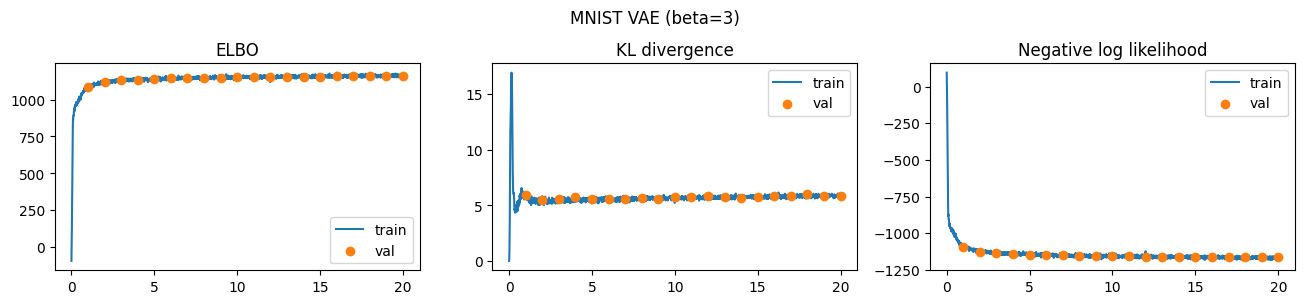

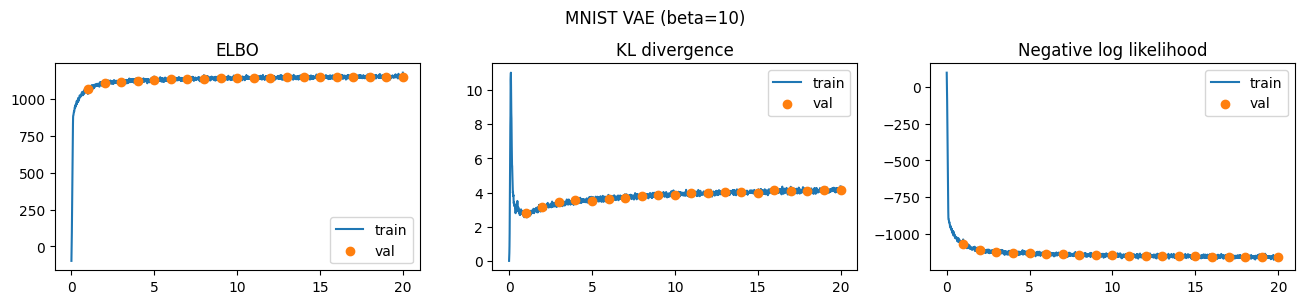

In [14]:
latent_dim = 2
input_size = 28*28
latent_size = 2
encoder_sizes = [512]
decoder_sizes = [512]
num_epochs = 20

### START CODE HERE ###
autoencoder = Autoencoder(latent_dim).to(device)
ae_opt = optim.Adam(autoencoder.parameters(), lr=1e-3)
train_ae(autoencoder, data, ae_opt, num_epochs=num_epochs)

all_betas = [1, 3, 10]
vae_models = {}
for beta in all_betas:
    vae = VAE(
        input_size=input_size,
        latent_size=latent_size,
        encoder_sizes=encoder_sizes,
        decoder_sizes=decoder_sizes,
        flatten=True,   
        sigmoid=True    
    ).to(device)
    vae_opt = optim.Adam(vae.parameters(), lr=1e-3)
    fig, _ = train_vae(
        vae, vae_opt, train_loader=data, val_loader=val_data,
        test_loader=None, figtitle=f"MNIST VAE (beta={beta})",
        num_epochs=num_epochs, beta=beta
    )
    fig.savefig(outdir / f'part_b_vae_beta_{beta}.png', bbox_inches='tight')
    vae_models[beta] = vae
### END CODE HERE ###

### Task B3:  Visualize the latent space

**Objective:** Compare latent space organization across all four model variants using 2D scatter plots.

**Visualization Requirements:**
- Create scatter plots for AE and VAE models (β=[1,3,10])
- Use MNIST digit labels (0-9) for color coding
- Sample >1500 random test images for clear visualization
- Plot latent encodings directly (no dimensionality reduction needed since latent_dim=2)

**Expected Observations:**
- **Autoencoder:** May show overlapping clusters
- **VAE (β=3,10):** Better separated clusters, more organized structure

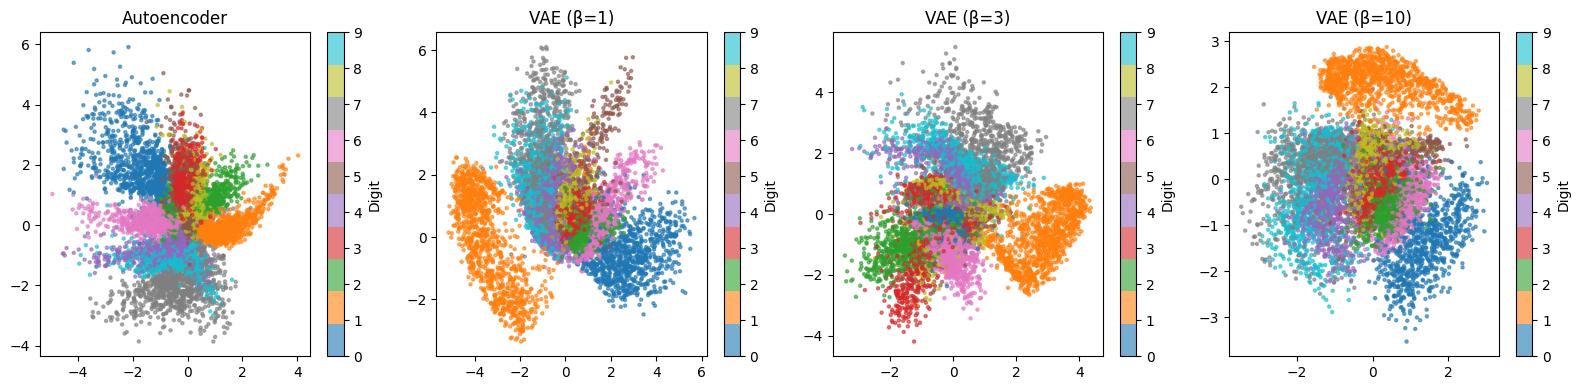

In [15]:
def plot_latent2D(model, data, num_batches=8, title=None, plot_idx=0):
    plt.subplot(1,4,plot_idx+1)
    ### START CODE HERE ###
    latent_rep = []
    labels = []
    model.eval()
    with torch.no_grad():
        for x, y in data:
            x = x.to(device)
            if hasattr(model, 'encoder'):  # For Autoencoder
                out = model.encoder(x.view(x.size(0), -1))
            else: 
                out = model.encode_latent(x)
            latent_rep.append(out.cpu().numpy())
            labels.append(y.numpy())

    latent_rep = np.concatenate(latent_rep, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    scatter = plt.scatter(latent_rep[:, 0], latent_rep[:, 1], c=labels, cmap='tab10', s=5, alpha=0.6)
    if title is not None:
        plt.title(title)
    plt.colorbar(scatter, label='Digit')
    ### END CODE HERE ###

# sample a subset of the test dataset randomly for better visualization
### START CODE HERE ###
plt.figure(figsize=(16, 4))
plot_latent2D(autoencoder, val_data, title='Autoencoder', plot_idx=0)
for i, beta in enumerate(all_betas):
    plot_latent2D(vae_models[beta], val_data, title=f'VAE (β={beta})', plot_idx=i+1)
plt.tight_layout()
plt.savefig(outdir / 'part_b_latent_space.png', bbox_inches='tight')
### END CODE HERE ###


### Task B4: Latent Space Sampling and Reconstruction

**Objective:** Explore the learned latent space by sampling from a uniform grid and visualizing reconstructions.

**Grid Sampling Setup:**
- **Autoencoder:** Sample from grid x,y ∈ [-5,5] (12×12 points)
- **VAEs:** Sample from grid x,y ∈ [-3,3] (12×12 points)
- Use `np.linspace()` to create evenly spaced grid points

**Visualization:**
- Decode each grid point to generate 28×28 images
- Arrange reconstructions in a 12×12 grid layout
- Create one visualization per model (4 total)


Randomly sample the latent space of the models and visualize the reconstructions. Sample latent vectors $z$ from the latent space over a uniform grid and plot the reconstructions on a grid. 

Hint: Use `np.linspace` with 2 loops (optional implementation).

You should be able to observe that the reconstructed latent vectors look like digits, and the kind of digit corresponds to the location of the latent vector in the latent space.

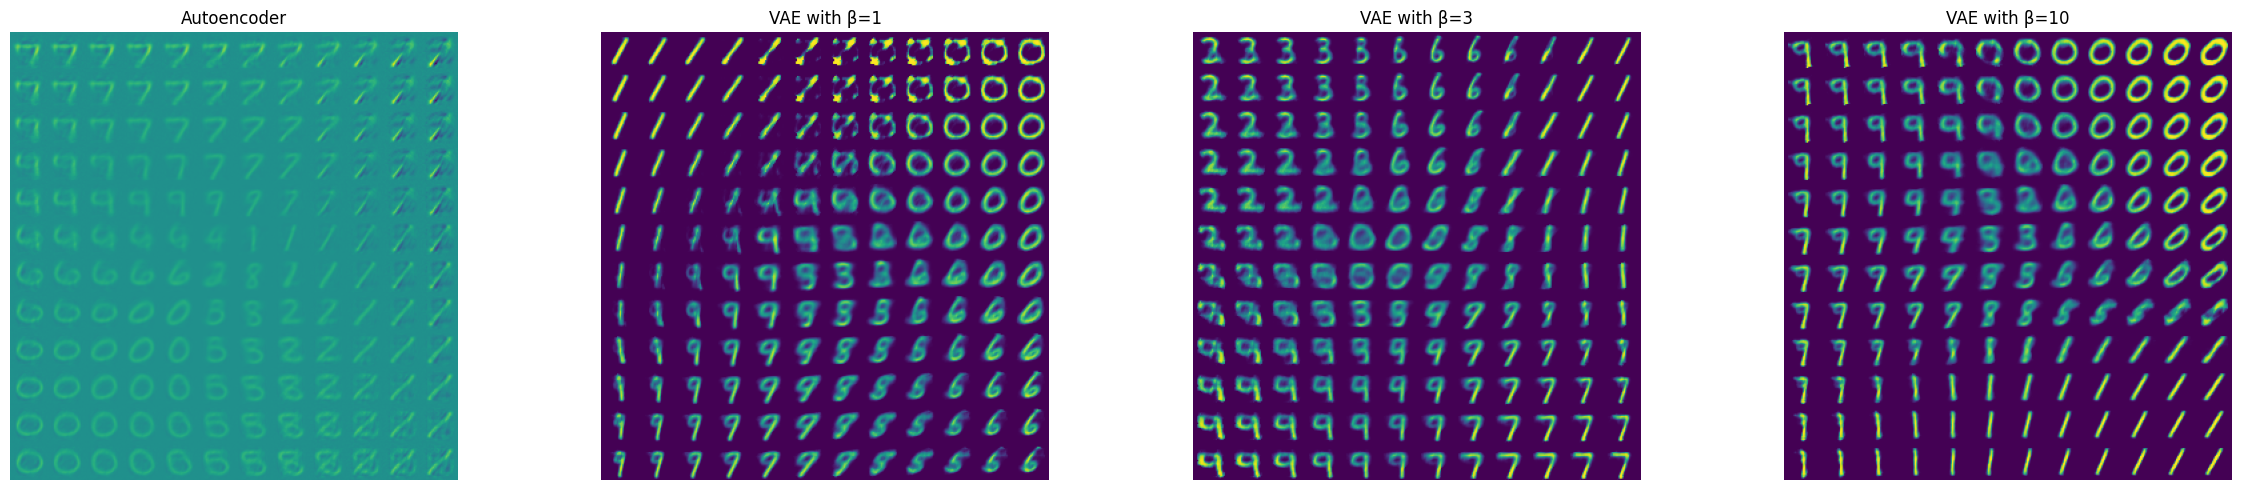

In [16]:
def plot_reconstructed(model, r0=(-5, 5), r1=(-5, 5), vae=False, n=12, title=None, plot_idx=0):
    w=28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            ### START CODE HERE ###
            input = torch.tensor([[x, y]], dtype=torch.float32, device=device)
            
            model.eval()
            with torch.no_grad():
                if vae:
                    x_recon, _, _ = model.decode(input, noise=False)
                else:
                    x_recon = model.decode(input)

                x_recon = x_recon.view(w, w).cpu().numpy()
            
            img[i*w:(i+1)*w, j*w:(j+1)*w] = x_recon
            ### END CODE HERE ###
    plt.subplot(1,4,plot_idx+1)
    plt.imshow(img, extent=[*r0, *r1])
    if title is not None:
        plt.title(title)
    plt.axis('off')

fig, axes = plt.subplots(1,4, figsize=(24,5))
### START CODE HERE ###
plot_reconstructed(autoencoder, r0=(-5, 5), r1=(-5, 5), vae=False, n=12, title='Autoencoder', plot_idx=0)

for i, beta in enumerate(all_betas):
    plot_reconstructed(vae_models[beta], r0=(-3, 3), r1=(-3, 3), vae=True, n=12, title=f'VAE with β={beta}', plot_idx=i+1)

plt.tight_layout()
### END CODE HERE ###
plt.savefig(outdir / 'part_b_reconstructions.png', bbox_inches='tight')

### Task B5: Latent Space Interpolation

**Objective:** Demonstrate smooth interpolation between different digits in latent space. Given two inputs $x_1$ and $x_2$, and their corresponding latent vectors $z_1$ and $z_2$, interpolate between them by decoding latent vectors between $x_1$ and $x_2$. 

**Procedure:**
1. Select one random digit with label 0 and one with label 1
2. Encode both images to get latent vectors z₁ and z₂
3. Create interpolation path: z(t) = z₁ + (z₂ - z₁) × t, where t ∈ [0,1]
4. Use n=15 equally spaced values of t
5. Reconstruct the images for the interpolated values and plot them in a single row.

Do the aforementioned for the all 4 model configurations.

**Mathematical Formula:**
z_interpolated = z₁ + (z₂ - z₁) × t, where t = [0, 1/14, 2/14, ..., 1]

**Implementation for All Models:**
- Repeat interpolation for autoencoder and all three VAE variants
- Display results in 4 rows (one per model)
- Compare smoothness and quality of transitions

**Expected Observations:**
- VAEs typically show smoother, more meaningful interpolations



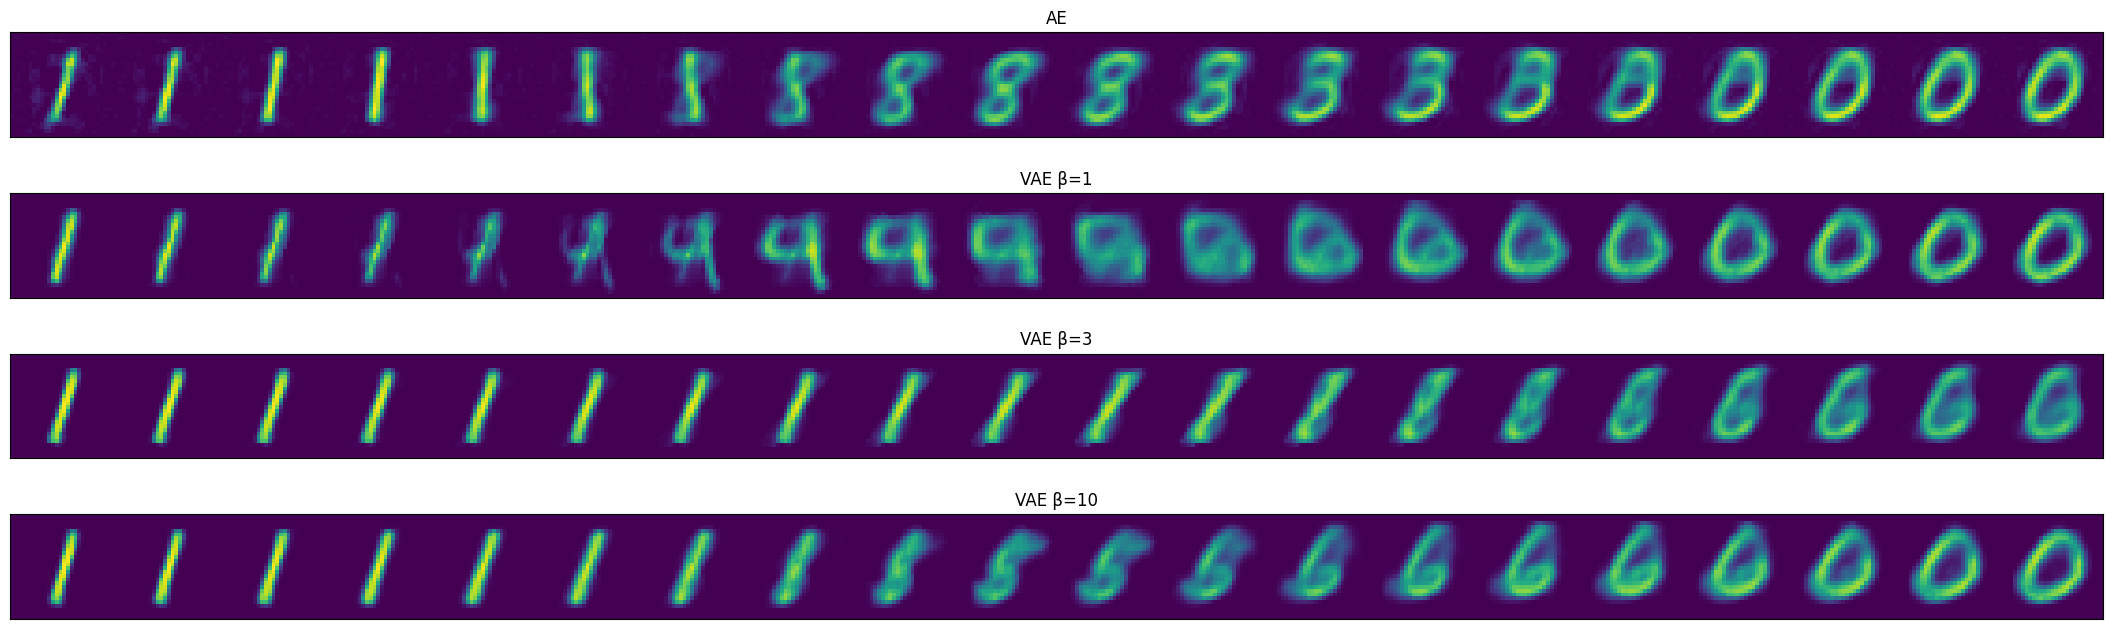

In [17]:
def interpolate(model, x_1, x_2, n=20, vae=False, title=None, plot_idx=0):
    w = 28
    img = np.zeros((w, n*w))
    ### START CODE HERE ###
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        x1 = x_1.to(device)  
        x2 = x_2.to(device)  

        if not vae:
            z1 = model.encoder(x1)            
            z2 = model.encoder(x2)            
            t = torch.linspace(0, 1, n, device=device).unsqueeze(1)  
            z_path = z1 + (z2 - z1) * t       
            x_recon = model.decode(z_path)    
        else:
            x1_in, x2_in = x1, x2
            if getattr(model, 'flatten', False):
                x1_in = x1_in.view(x1_in.size(0), -1)  
                x2_in = x2_in.view(x2_in.size(0), -1)  
            z1 = model.encode(x1_in)       
            mu1, _ = z1.chunk(2, dim=1)       
            z2 = model.encode(x2_in)       
            mu2, _ = z2.chunk(2, dim=1)       
            t = torch.linspace(0, 1, n, device=device).unsqueeze(1)  
            z_path = mu1 + (mu2 - mu1) * t    
            _, mu_x, _ = model.decode(z_path, noise=False)  
            x_recon = mu_x.view(n, 1, 28, 28)  

        x_recon = x_recon.clamp(0, 1).cpu().numpy()
        for k in range(n):
            img[:, k*w:(k+1)*w] = x_recon[k, 0]
    ### END CODE HERE ###
    plt.subplot(4,1,plot_idx+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title)
  
fig, axes = plt.subplots(4,1, figsize=(27,8))

# find a sample with label 1 and 0, with variavble names x_1, x_2
### START CODE HERE ###
def first_with_label(loader, label):
    for xb, yb in loader:
        idxs = (yb == label).nonzero(as_tuple=False)
        if idxs.numel():
            i = idxs[0].item()
            return xb[i:i+1]  
    return None

x_1 = first_with_label(val_data, 1)
x_2 = first_with_label(val_data, 0)

# draw 4 rows
interpolate(autoencoder, x_1, x_2, n=20, vae=False, title='AE',plot_idx=0)
interpolate(vae_models[1],x_1, x_2, n=20, vae=True, title='VAE β=1',plot_idx=1)
interpolate(vae_models[3],x_1, x_2, n=20, vae=True, title='VAE β=3', plot_idx=2)
interpolate(vae_models[10],x_1, x_2, n=20, vae=True, title='VAE β=10', plot_idx=3)
### END CODE HERE ###

plt.savefig(outdir / 'part_b_interpolations.png', bbox_inches='tight')